In [1]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- ATLAS style ---
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()

ROOT.EnableImplicitMT()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully!")

# Input ROOT file
fdir = delphes_dir + "displacedPhoton/non_dark_events.root"
df = ROOT.RDataFrame("Delphes", fdir)

FINAL_STATUS = 62


Applying ATLAS style settings...

libDelphes.so loaded successfully!


In [2]:
# --- Convert truth particles to pandas ---
particle_dict = df.AsNumpy([
    "Event.Number",
    "Particle.PT",
    "Particle.Eta",
    "Particle.Phi",
    "Particle.Mass",
    "Particle.PID",
    "Particle.fUniqueID",
    "Particle.M1",
    "Particle.M2",
    "Particle.D1",
    "Particle.D2",
    "Particle.P",
    "Particle.Status",
    "Particle.Charge",
    "Particle.T"
])

# Flatten event numbers (scalars, not 1-element arrays)
event_numbers = [arr[0] for arr in particle_dict["Event.Number"]]

# Add particle indices per event (needed for mother/daughter lookup)
particle_dict["Particle.Index"] = [
    np.arange(len(pt)) for pt in particle_dict["Particle.PT"]
]

# Build DataFrame
particle_df = pd.DataFrame({
    "EventNumber": event_numbers,
    "ParticleIndex": particle_dict["Particle.Index"],
    "PT": particle_dict["Particle.PT"],
    "Eta": particle_dict["Particle.Eta"],
    "Phi": particle_dict["Particle.Phi"],
    "Mass": particle_dict["Particle.Mass"],
    "PID": particle_dict["Particle.PID"],
    "UniqueID": particle_dict["Particle.fUniqueID"],  # keep for reference
    "M1": particle_dict["Particle.M1"],
    "M2": particle_dict["Particle.M2"],
    "D1": particle_dict["Particle.D1"],
    "D2": particle_dict["Particle.D2"],
    "P": particle_dict["Particle.P"],
    "Status": particle_dict["Particle.Status"],
    "Charge": particle_dict["Particle.Charge"],
    "T": particle_dict["Particle.T"],
})

# Only look at the first 500 events for now
particle_df = particle_df[particle_df["EventNumber"] < 500]

# Explode so each particle gets its own row
particle_df = particle_df.explode([
    "ParticleIndex", "PT", "Eta", "Phi", "Mass", "PID", "UniqueID",
    "M1", "M2", "D1", "D2", "P", "Status", "Charge", "T"
], ignore_index=True)

# Convert indices to integer
particle_df[["ParticleIndex", "M1", "M2", "D1", "D2"]] = particle_df[["ParticleIndex", "M1", "M2", "D1", "D2"]].astype(int)

particle_df = particle_df.sort_values(by="EventNumber").reset_index(drop=True)

particle_df.head()


,EventNumber,ParticleIndex,PT,Eta,Phi,Mass,PID,UniqueID,M1,M2,D1,D2,P,Status,Charge,T
0,0,22,0.0,999.900024,1.570796,0.0,21,23,6,-1,39,40,-0.0,41,0,0.0
1,0,21,0.0,999.900024,1.487655,0.0,21,22,5,-1,37,38,-0.0,41,0,0.0
2,0,6,1.947162,5.31545,-0.17886,0.0,21,6,0,-1,22,22,-0.0,61,0,0.0
3,0,106,1.531283,-0.422398,-1.765054,0.0,21,104,103,-1,107,107,-0.0,51,0,0.0
4,0,105,2.596698,-2.474885,2.064316,0.0,21,103,103,-1,152,152,-0.0,51,0,0.0


In [3]:
# --- Helper: get children of a particle using D1..D2 indices ---
def get_children(df, parent_index, event_num):
    """Return daughter particles of parent_index within the same event (by ParticleIndex)."""
    parent = df[(df["ParticleIndex"] == parent_index) & (df["EventNumber"] == event_num)]
    if parent.empty:
        raise ValueError(f"Parent index {parent_index} not found in event {event_num}")
    parent = parent.iloc[0]
    d1, d2 = int(parent["D1"]), int(parent["D2"])
    if d1 < 0 or d2 < 0:
        return pd.DataFrame()  # no daughters
    return df[(df["EventNumber"] == event_num) & (df["ParticleIndex"] >= d1) & (df["ParticleIndex"] <= d2)]

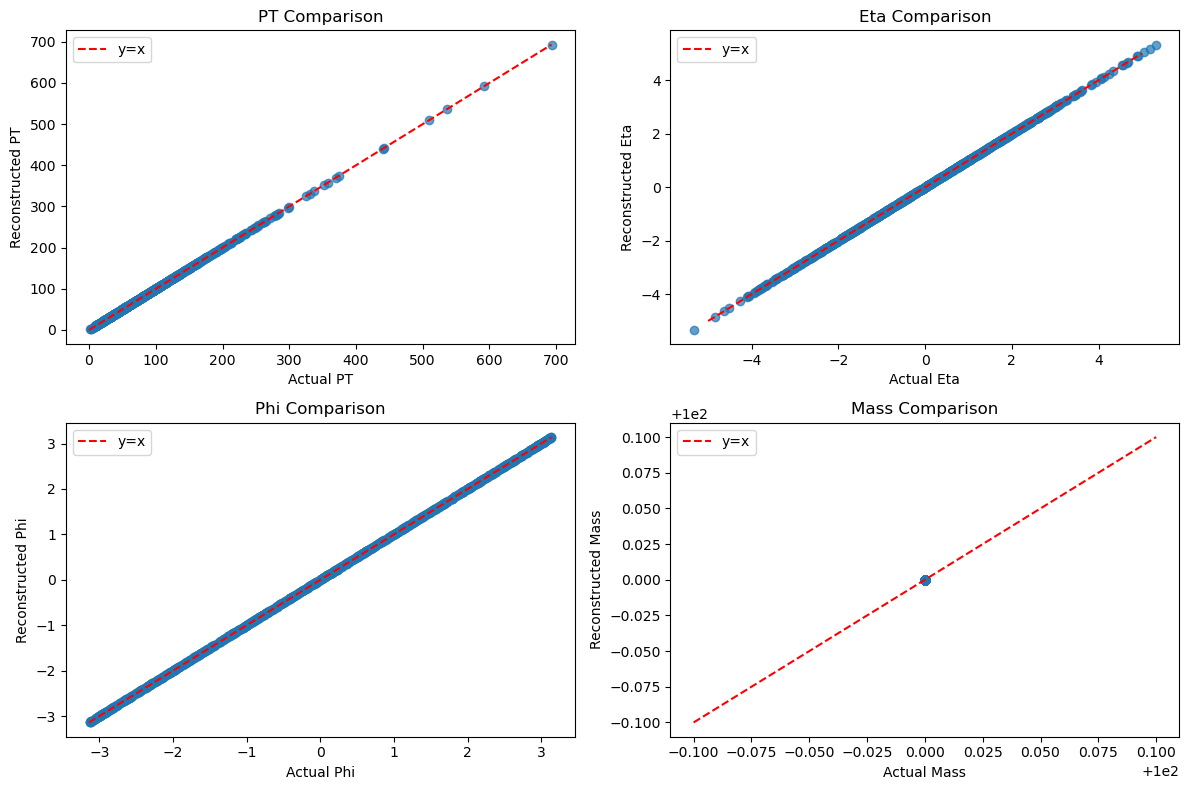

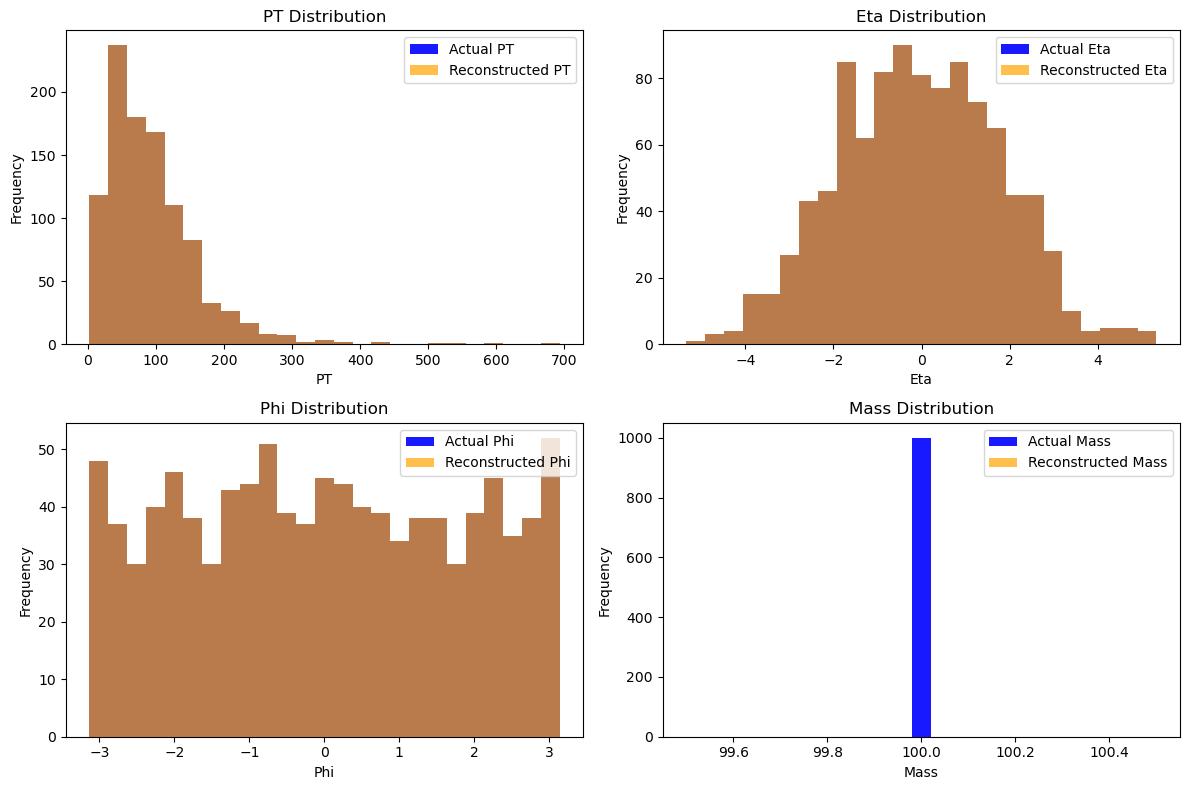

In [4]:
# --- Fill ROOT 4vector with PID54's children and reconstruct PID54 ---
reconstructed_properties = []

for ev in particle_df["EventNumber"].unique():
    ev_df = particle_df[particle_df["EventNumber"] == ev]
    pid54 = ev_df[(ev_df["PID"] == 54) & (ev_df["Status"] == FINAL_STATUS)]

    if pid54.empty:
        continue

    for _, parent in pid54.iterrows():
        children = get_children(ev_df, parent.ParticleIndex, ev)
        if children.empty:
            continue

        # Initialize ROOT 4vector for reconstructed PID54
        reconstructed_4vector = ROOT.TLorentzVector()

        for _, child in children.iterrows():
            child_4vector = ROOT.TLorentzVector()
            child_4vector.SetPtEtaPhiM(float(child["PT"]), float(child["Eta"]), float(child["Phi"]), float(child["Mass"]))
            reconstructed_4vector += child_4vector

        # Store reconstructed and actual properties for comparison
        reconstructed_properties.append({
            "EventNumber": ev,
            "ParentIndex": parent["ParticleIndex"],
            "Reconstructed_PT": reconstructed_4vector.Pt(),
            "Reconstructed_Eta": reconstructed_4vector.Eta(),
            "Reconstructed_Phi": reconstructed_4vector.Phi(),
            "Reconstructed_Mass": reconstructed_4vector.M(),
            "Actual_PT": float(parent["PT"]),
            "Actual_Eta": float(parent["Eta"]),
            "Actual_Phi": float(parent["Phi"]),
            "Actual_Mass": float(parent["Mass"]),
        })

# Convert to DataFrame for plotting
reconstructed_df = pd.DataFrame(reconstructed_properties)

# --- Plot comparisons ---
plt.figure(figsize=(12, 8))

# PT comparison
plt.subplot(2, 2, 1)
plt.scatter(reconstructed_df["Actual_PT"], reconstructed_df["Reconstructed_PT"], alpha=0.7)
plt.plot([0, reconstructed_df["Actual_PT"].max()], [0, reconstructed_df["Actual_PT"].max()], 'r--', label="y=x")
plt.xlabel("Actual PT")
plt.ylabel("Reconstructed PT")
plt.title("PT Comparison")
plt.legend()

# Eta comparison
plt.subplot(2, 2, 2)
plt.scatter(reconstructed_df["Actual_Eta"], reconstructed_df["Reconstructed_Eta"], alpha=0.7)
plt.plot([-5, 5],
         [-5, 5], 'r--', label="y=x")
plt.xlabel("Actual Eta")
plt.ylabel("Reconstructed Eta")
plt.title("Eta Comparison")
plt.legend()

# Phi comparison
plt.subplot(2, 2, 3)
plt.scatter(reconstructed_df["Actual_Phi"], reconstructed_df["Reconstructed_Phi"], alpha=0.7)
plt.plot([-np.pi, np.pi],
         [-np.pi, np.pi], 'r--', label="y=x")
plt.xlabel("Actual Phi")
plt.ylabel("Reconstructed Phi")
plt.title("Phi Comparison")
plt.legend()

# Mass comparison
plt.subplot(2, 2, 4)
plt.scatter(reconstructed_df["Actual_Mass"], reconstructed_df["Reconstructed_Mass"], alpha=0.7)
plt.plot([99.9, 100.1], [99.9, 100.1], 'r--', label="y=x")
plt.xlabel("Actual Mass")
plt.ylabel("Reconstructed Mass")
plt.title("Mass Comparison")
plt.legend()

plt.tight_layout()
plt.savefig("plots/reconstructed_vs_actual_corr.png")
plt.show()

# --- Stacked histograms for truth and reconstructed values ---
plt.figure(figsize=(12, 8))

# PT histogram
plt.subplot(2, 2, 1)
plt.hist(reconstructed_df["Actual_PT"], bins=25, alpha=0.9, label="Actual PT", color="blue")
plt.hist(reconstructed_df["Reconstructed_PT"], bins=25, alpha=0.7, label="Reconstructed PT", color="orange")
plt.xlabel("PT")
plt.ylabel("Frequency")
plt.title("PT Distribution")
plt.legend()

# Eta histogram
plt.subplot(2, 2, 2)
plt.hist(reconstructed_df["Actual_Eta"], bins=25, alpha=0.9, label="Actual Eta", color="blue")
plt.hist(reconstructed_df["Reconstructed_Eta"], bins=25, alpha=0.7, label="Reconstructed Eta", color="orange")
plt.xlabel("Eta")
plt.ylabel("Frequency")
plt.title("Eta Distribution")
plt.legend()

# Phi histogram
plt.subplot(2, 2, 3)
plt.hist(reconstructed_df["Actual_Phi"], bins=25, alpha=0.9, label="Actual Phi", color="blue")
plt.hist(reconstructed_df["Reconstructed_Phi"], bins=25, alpha=0.7, label="Reconstructed Phi", color="orange")
plt.xlabel("Phi")
plt.ylabel("Frequency")
plt.title("Phi Distribution")
plt.legend()

# Mass histogram
plt.subplot(2, 2, 4)
plt.hist(reconstructed_df["Actual_Mass"], bins=25, alpha=0.9, label="Actual Mass", color="blue")
plt.hist(reconstructed_df["Reconstructed_Mass"], bins=25, alpha=0.7, label="Reconstructed Mass", color="orange")
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.title("Mass Distribution")
plt.legend()

plt.tight_layout()
plt.savefig("plots/reconstructed_vs_actual_hist.png")
plt.show()

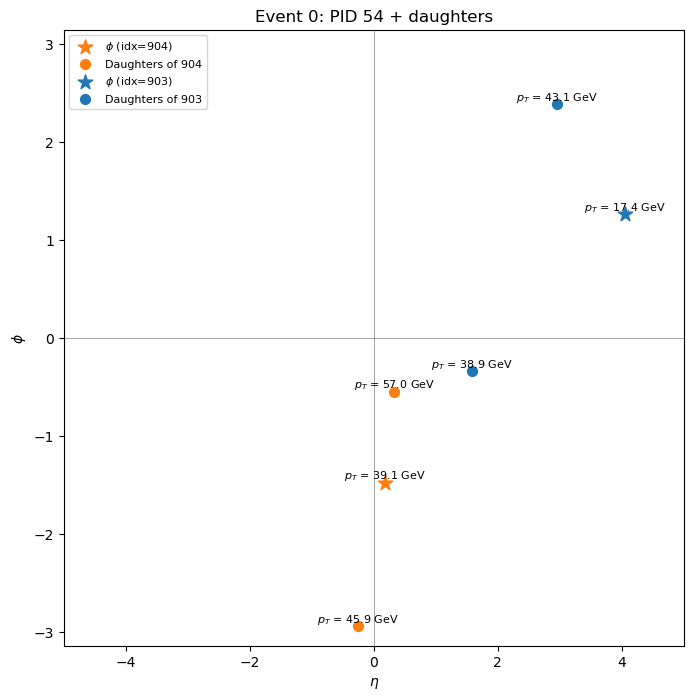

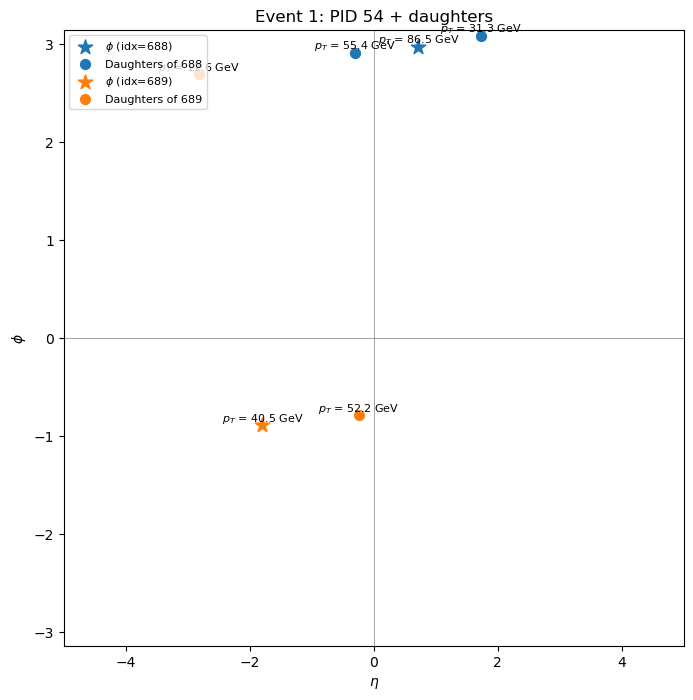

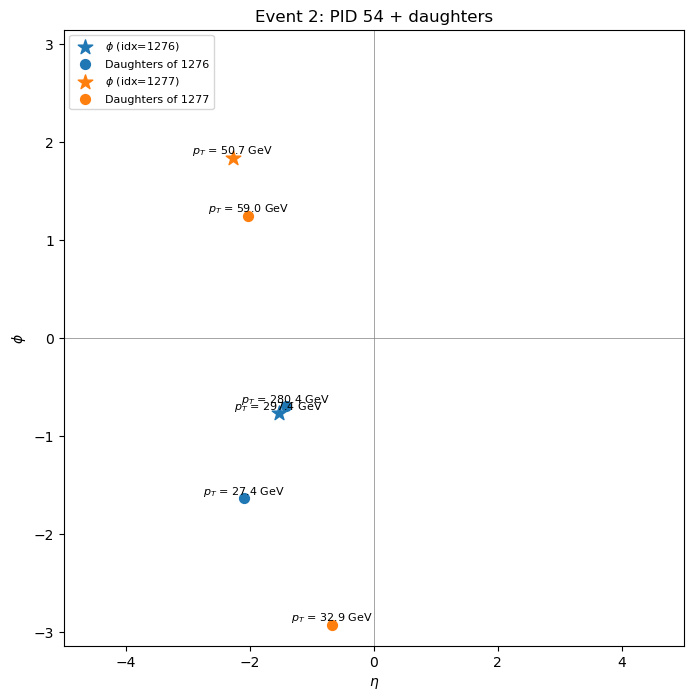

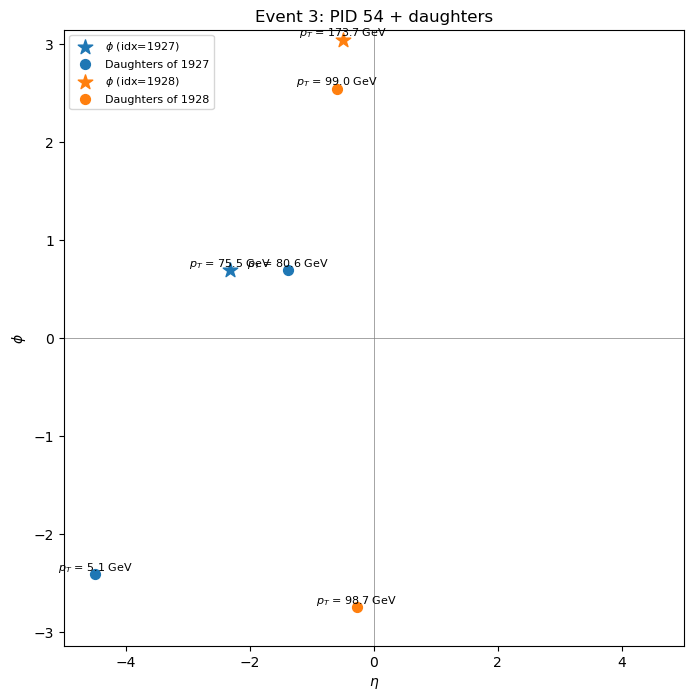

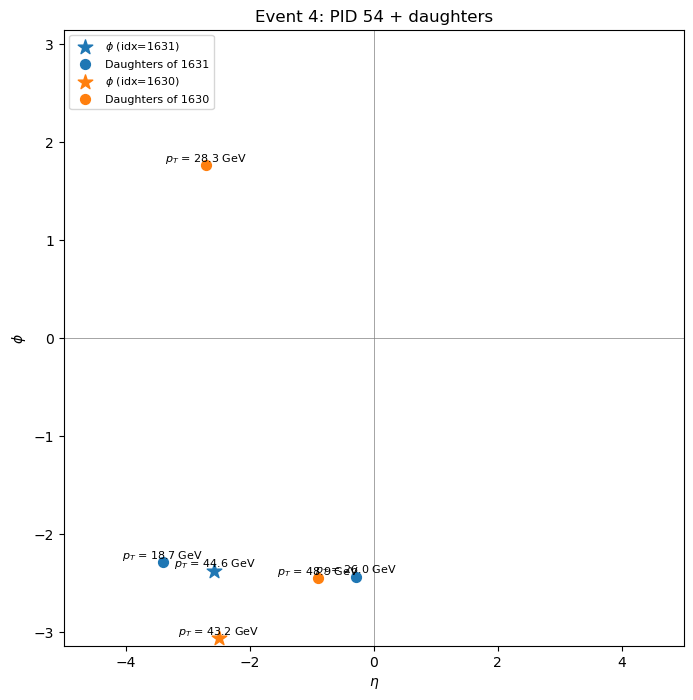

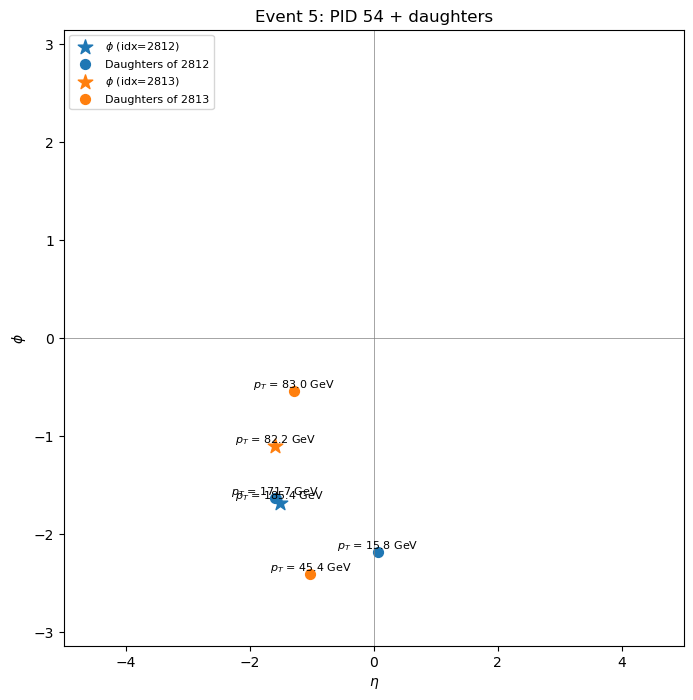

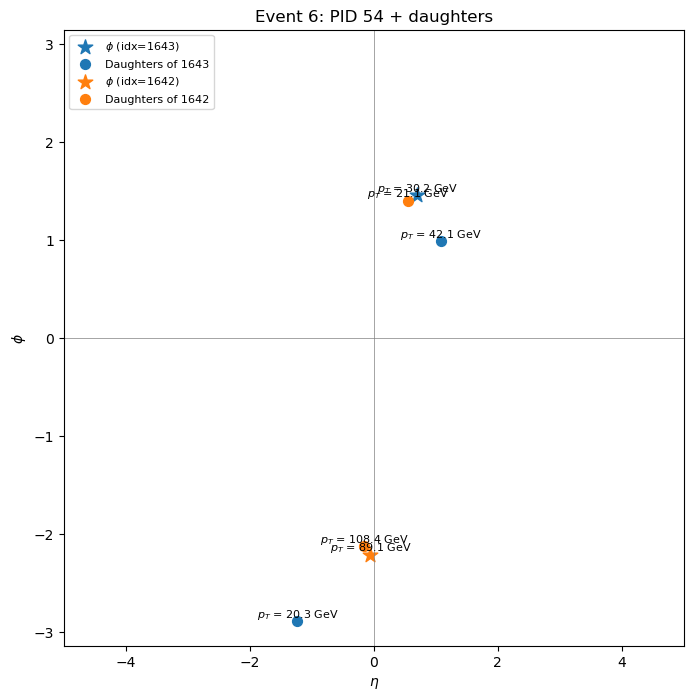

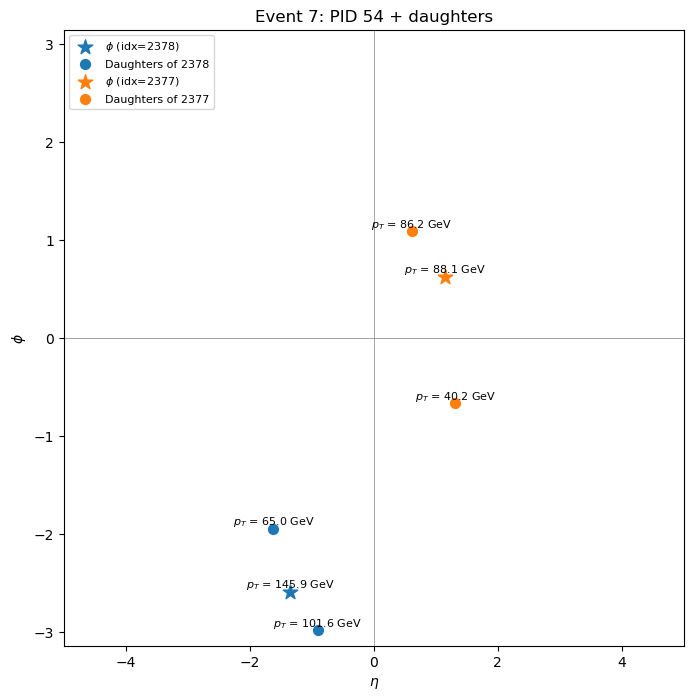

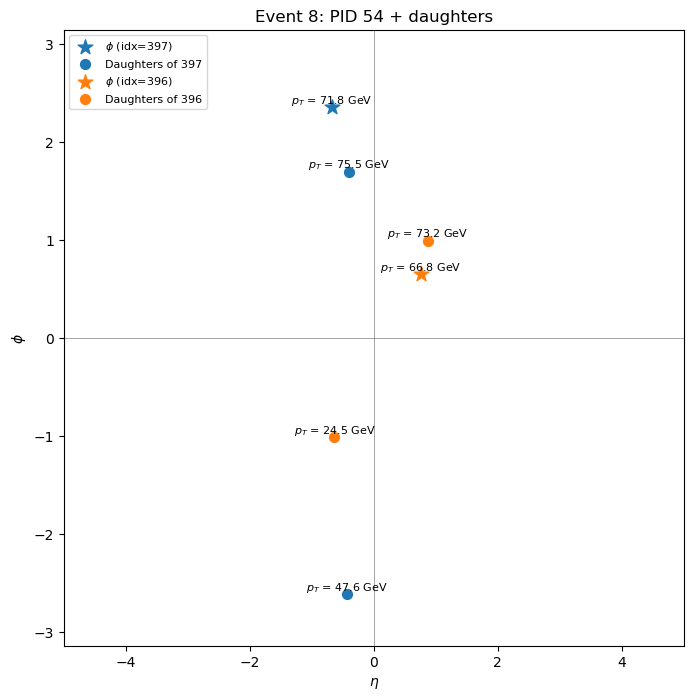

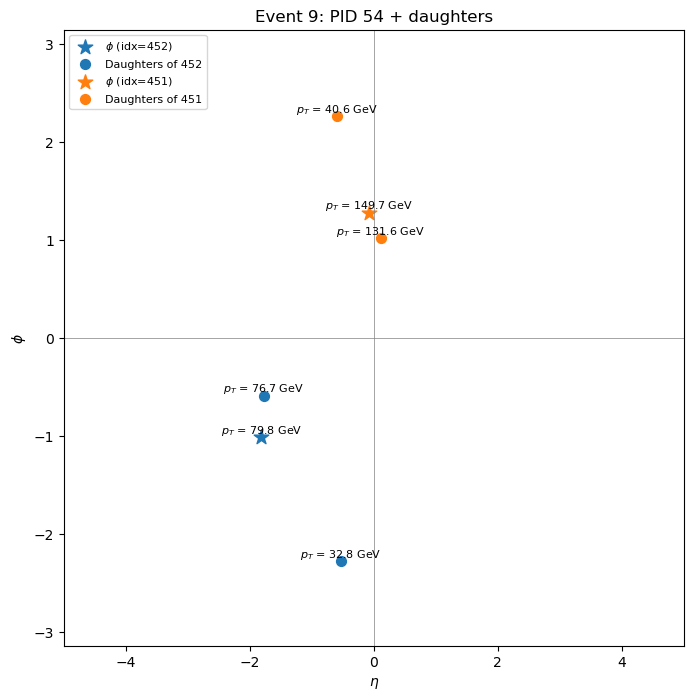

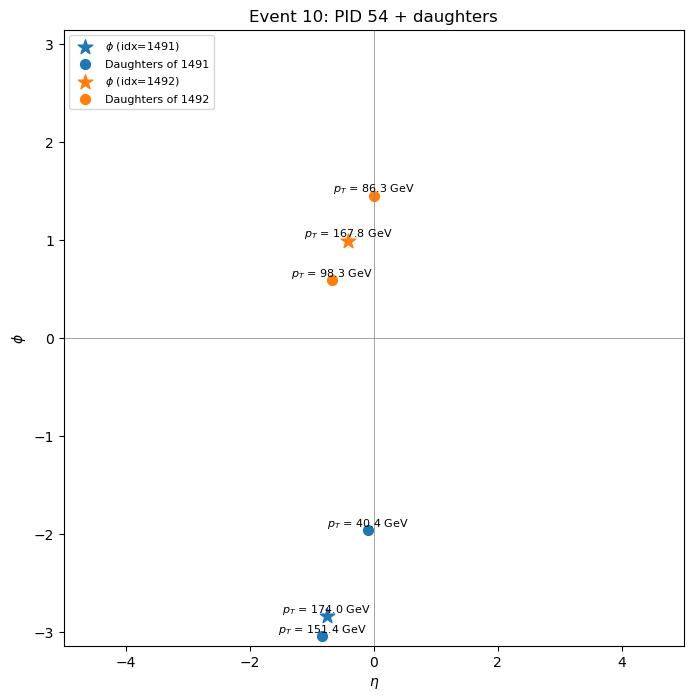

In [5]:
# --- Loop over events, find PID=54, plot daughters ---
for ev in particle_df["EventNumber"].unique():
    ev_df = particle_df[particle_df["EventNumber"] == ev]
    pid54 = ev_df[ev_df["PID"] == 54]

    if pid54.empty:
        continue
        
    plt.figure(figsize=(8, 8))
    plt.axhline(0, color="gray", lw=0.5)
    plt.axvline(0, color="gray", lw=0.5)

    for i, (_, parent) in enumerate(pid54.iterrows()):
        if parent["Status"] != FINAL_STATUS:
            continue
        children = get_children(ev_df, parent.ParticleIndex, ev)
        if not children.empty and not children["PID"].isin([22]).all():
            print(f"Warning: Parent {parent.ParticleIndex} in event {ev} has non-photon daughters")
            continue
        
        # Generate a unique color for each parent
        i%=2
        color = "tab:blue" if i == 0 else "tab:orange"

        # Plot parent
        plt.scatter(parent["Eta"], parent["Phi"], c=color, marker="*", s=120, label=fr"$\phi$ (idx={parent.ParticleIndex})")
        plt.text(parent["Eta"], parent["Phi"], f"$p_{{T}}$ = {parent['PT']:.1f} GeV", fontsize=8, ha='center', va='bottom', color='black')

        # Plot children
        if not children.empty:
            plt.scatter(children["Eta"], children["Phi"], c=color, marker="o", s=50, label=f"Daughters of {parent.ParticleIndex}")
            for _, child in children.iterrows():
                plt.text(child["Eta"], child["Phi"], f"$p_{{T}}$ = {child['PT']:.1f} GeV", fontsize=8, ha='center', va='bottom', color='black')
                assert child["PID"] == 22, f"Expected photon (PID=22), got PID={child['PID']}"
        
    plt.xlabel(r"$\eta$")
    plt.ylabel(r"$\phi$")
    plt.xlim(-5, 5)
    plt.ylim(-np.pi, np.pi)
    plt.title(f"Event {ev}: PID 54 + daughters")
    plt.legend(loc='upper left', fontsize=8)
    
    print_display = 0
    
    if ev == print_display:
        plt.savefig(f"plots/non_dark_event_{ev}_display.png", bbox_inches='tight')
        
    plt.show()
        
    if ev >= 10:  # limit number of events displayed
        break
